# Crawler to retrieve houses from Funda.nl

<h1 align='center'>=========================================================</h1>

# PART I:  manual crawler of funda.nl pages

## Needed libraries

In [34]:
import pandas as pd

import cfscrape
from lxml import etree
header = {'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9',
              'Accept-Encoding': 'gzip, deflate, sdch',
              'Accept-Language' : 'nl-NL,nl;q=0.8,en-US;q=0.6,en;q=0.4',
              'Cache-Control' : 'max-age=0',
              'Connection': 'keep-alive',
              'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.81 Safari/537.36'}
scraper = cfscrape.create_scraper()

## Retrieving all links of houses in ONE page of funda.nl

In [220]:
page = 1
url="https://www.funda.nl/koop/enschede/0-500000/woonhuis/p"+str(page)

In [221]:
scraped_html=scraper.get(url,headers=header).content.decode("utf-8") 
html = etree.HTML(scraped_html)
# print(scraped_html)

In [222]:
df_links = pd.DataFrame(html.xpath("//div/a/@href"))
df_links_unique = 'https://www.funda.nl'+ df_links[df_links[0].str.contains("/koop/enschede/huis")].drop_duplicates()
df_links_unique[0].tolist()

['https://www.funda.nl/koop/enschede/huis-87141126-deurningerstraat-315/',
 'https://www.funda.nl/koop/enschede/huis-87351405-bultsweg-92/',
 'https://www.funda.nl/koop/enschede/huis-41630450-multatulistraat-18/',
 'https://www.funda.nl/koop/enschede/huis-41912290-bosbeekjuffer-18/',
 'https://www.funda.nl/koop/enschede/huis-41910179-thomas-de-keyserstraat-276/',
 'https://www.funda.nl/koop/enschede/huis-41918630-citroenvlinder-68/',
 'https://www.funda.nl/koop/enschede/huis-41916896-bw-ter-kuilestraat-348/',
 'https://www.funda.nl/koop/enschede/huis-41916582-markslaghoek-23/',
 'https://www.funda.nl/koop/enschede/huis-41900125-walkottelanden-91/',
 'https://www.funda.nl/koop/enschede/huis-41900041-minister-de-savornin-lohmanlaan-28/',
 'https://www.funda.nl/koop/enschede/huis-41900087-wienebrink-18/',
 'https://www.funda.nl/koop/enschede/huis-41900934-drienerweg-30/',
 'https://www.funda.nl/koop/enschede/huis-41900802-steenbeltweg-59/',
 'https://www.funda.nl/koop/enschede/huis-419093

## Retrieving all information of ONE house in funda.nl

In [165]:
url="https://www.funda.nl/koop/enschede/huis-41900041-minister-de-savornin-lohmanlaan-28/"

In [166]:
scraped_html=scraper.get(url,headers=header).content.decode("utf-8") 
html = etree.HTML(scraped_html)
# print(scraped_html)

In [167]:
title = html.xpath("//title/text()")[0].replace('Huis te koop: ','').replace('[funda]','')
price = html.xpath("//strong[@class='object-header__price']/text()")[0].replace('€ ','').replace(' /mnd','').replace('.','').replace(' kk','')
bouwjaar = html.xpath("//dl[@class='object-kenmerken-list']")[1].xpath("dd/text()")[2].replace('\r\n','').strip()
kamers = html.xpath("//dl[@class='object-kenmerken-list']")[3].xpath("dd/text()")[0].replace('\r\n','')
woonlagen = html.xpath("//dl[@class='object-kenmerken-list']")[3].xpath("dd/text()")[1].replace('\r\n','')
woonen_m2 = html.xpath("//dd[@class='object-kenmerken-group-list']/dl/dd[1]/text()")[0].replace('\r\n','').replace(' m²','')
perceel_m2 = html.xpath("//dd[@class='object-kenmerken-group-list']/dl/dd[1]/text()")[1].replace('\r\n','').replace(' m²','')

makelaars = html.xpath("//a[@class='object-contact-aanbieder-link']/text()")[0]
makelaars_phone = html.xpath("//span[@class='fd-completely-hidden fd-display-inline-block--bp-m']/text()")[0].replace('\r\n','').strip()

print(url,
      title,
      price,
      bouwjaar,
      kamers,
      woonlagen, 
      woonen_m2,
      perceel_m2,
      makelaars,
      makelaars_phone,
      sep='\n')

https://www.funda.nl/koop/enschede/huis-41900041-minister-de-savornin-lohmanlaan-28/
Minister De Savornin Lohmanlaan 28 7522 AP Enschede 
325000
1954
6 kamers (4 slaapkamers)
1 badkamer en 1 apart toilet
141
335
Thoma Post Makelaars Enschede
053-4340038


<h1 align='center'>=========================================================</h1>

# PART II: defining a function to automatic crawler all houses to buy from funda.nl

In [244]:
def funda_automatic_crawler (city, price_max):
    
    page = 1
    links = []
    
    while True:
        url="https://www.funda.nl/koop/"+str(city)+"/0-"+str(price_max)+"/woonhuis/p"+str(page)
        scraped_html=scraper.get(url,headers=header).content.decode("utf-8") 
        html = etree.HTML(scraped_html)
        
        df_links = pd.DataFrame(html.xpath("//div/a/@href"))
        df_links_unique = 'https://www.funda.nl'+ df_links[df_links[0].str.contains("/koop/enschede/huis")].drop_duplicates()
        links.extend(df_links_unique[0].tolist())
        
        print("Links from page",page,"retrieved!")
        
        total_entries = int(html.xpath("//button[@class='mobile-search-sticky-button fd-btn fd-btn--primary']/span/text()")[0].replace("koopwoningen",'').strip())
        
        if page * 10 > total_entries:
            break
        else:
            page = page + 1
#   -------------------------------------------
    links_unique = list(set(links))
    df = pd.DataFrame()
    for url in links_unique:
        scraped_html=scraper.get(url,headers=header).content.decode("utf-8") 
        html = etree.HTML(scraped_html)
        
        try:
            title = html.xpath("//title/text()")[0].replace('Huis te koop: ','').replace('[funda]','')
        except:
            title = ""
            
        try:
            price = html.xpath("//strong[@class='object-header__price']/text()")[0].replace('€ ','').replace(' /mnd','').replace('.','').replace(' kk','')
        except:
            prince = ""
            
        try:
            bouwjaar = html.xpath("//dl[@class='object-kenmerken-list']")[1].xpath("dd/text()")[2].replace('\r\n','').strip()
        except:
            bouwjaar =""
            
        try:
            kamers = html.xpath("//dl[@class='object-kenmerken-list']")[3].xpath("dd/text()")[0].replace('\r\n','')
        except:
            kamers = ""
            
        try:
            woonlagen = html.xpath("//dl[@class='object-kenmerken-list']")[3].xpath("dd/text()")[1].replace('\r\n','')
        except:
            woonlagen = ""
        
        try:
            woonen_m2 = html.xpath("//dd[@class='object-kenmerken-group-list']/dl/dd[1]/text()")[0].replace('\r\n','').replace(' m²','')
        except:
            woonen_m2 = ""
            
        try:
            perceel_m2 = html.xpath("//dd[@class='object-kenmerken-group-list']/dl/dd[1]/text()")[1].replace('\r\n','').replace(' m²','')
        except:
            perceel_m2 =""
        
        try:
            makelaars = html.xpath("//a[@class='object-contact-aanbieder-link']/text()")[0]
        except:
            makelaars = ""
        
        try:
            makelaars_phone = html.xpath("//span[@class='fd-completely-hidden fd-display-inline-block--bp-m']/text()")[0].replace('\r\n','').strip()
        except:
            makelaars_phone = ""
        
        print("Retrieved:", title)
        df_temp = pd.DataFrame({'link':url,
                                'title':[title],
                                'city':[city],
                                'price':[price],
                                'bouwjaar': [bouwjaar],
                                'kamers': [kamers],
                                'woonlagen': [woonlagen],
                                'woonen_m2':[woonen_m2],
                                'perceel_m2':[perceel_m2],
                                'makelaars': [makelaars],
                                'makelaars_phone':[makelaars_phone]})
        
        df = pd.concat([df,df_temp], axis=0, ignore_index=True)
    return df

In [245]:
df = funda_automatic_crawler('enschede',500000)

Links from page 1 retrieved!
Links from page 2 retrieved!
Links from page 3 retrieved!
Links from page 4 retrieved!
Links from page 5 retrieved!
Links from page 6 retrieved!
Links from page 7 retrieved!
Links from page 8 retrieved!
Links from page 9 retrieved!
Links from page 10 retrieved!
Links from page 11 retrieved!
Links from page 12 retrieved!
Links from page 13 retrieved!
Links from page 14 retrieved!
Links from page 15 retrieved!
Links from page 16 retrieved!
Links from page 17 retrieved!
Links from page 18 retrieved!
Links from page 19 retrieved!
Links from page 20 retrieved!
Links from page 21 retrieved!
Links from page 22 retrieved!
Links from page 23 retrieved!
Links from page 24 retrieved!
Links from page 25 retrieved!
Links from page 26 retrieved!
Links from page 27 retrieved!
Links from page 28 retrieved!
Links from page 29 retrieved!
Links from page 30 retrieved!
Links from page 31 retrieved!
Links from page 32 retrieved!
Links from page 33 retrieved!
Links from page 34 

Retrived: Hoekwoning (Bouwnr. 11) 7512 EM Enschede 
Retrived: Roerstraat 37 7523 TK Enschede 
Retrived: Perikweg 59 7512 DN Enschede 
Retrived: Wederiklaan 70 7534 KV Enschede 
Retrived: Velveweg 174 7533 XL Enschede 
Retrived: Elferinksweg 125 7545 KC Enschede 
Retrived: Stentorlaan 11 7534 HT Enschede 
Retrived: Bouwnummer (Bouwnr. 7) 7513 EV Enschede 
Retrived: Lipperkerkstraat 98 7511 DC Enschede 
Retrived: Begoniastraat 103 7514 ZS Enschede 
Retrived: Van der Waalslaan 1 7535 CN Enschede 
Retrived: Stroinksbleekweg 44 7523 ZL Enschede 
Retrived: Kalkerlanden 26 7542 WG Enschede 
Retrived: Torricellistraat 24 7535 DH Enschede 
Retrived: Pathmossingel 191 7513 CG Enschede 
Retrived: Laaressingel 78 7514 EV Enschede 
Retrived: Sparrendaal 157 7544 NP Enschede 
Retrived: Hulststraat 2 7544 TK Enschede 
Retrived: W.C. Schoutenstraat 18 7532 XX Enschede 
Retrived: Hogelandsingel 83 7512 GC Enschede 
Retrived: Rozenstraat 91 7514 ZN Enschede 
Retrived: Bosuilstraat 26 7523 BK Enschede 
R

Retrived: Gronausestraat 46 7533 BN Enschede 
Retrived: Bouwkavel "De Bult" (Bouwnr. 1) 7532 XL Enschede 
Retrived: Oosterstraat 4 7514 DZ Enschede 
Retrived: Europalaan 144 7543 DJ Enschede 
Retrived: Nieuwluststraat 33 7523 XA Enschede 
Retrived: Kampioenstraat 12 7535 BJ Enschede 
Retrived: Hanenberglanden 131 7542 EV Enschede 
Retrived: Zomervlinder 43 7534 MG Enschede 
Retrived: Topaasstraat 42 7548 CL Enschede 
Retrived: Salviastraat 42 7531 VX Enschede 
Retrived: Atalantalaan 9 7534 HK Enschede 
Retrived: Etudestraat 45 7534 EP Enschede 
Retrived: Multatulistraat 18 7514 CZ Enschede 
Retrived: Reudinkstraat 31 A 7511 ZG Enschede 
Retrived: Hanenberglanden 133 7542 EV Enschede 
Retrived: Vlierstraat 31 7544 GE Enschede 
Retrived: Mercuriusplein 30 7521 WV Enschede 
Retrived: Haydnlaan 37 7522 HD Enschede 
Retrived: Varviksingel 219 7512 EM Enschede 
Retrived: Stokkumbrink 48 7544 EC Enschede 
Retrived: Pijlkruidlaan 50 7534 JJ Enschede 
Retrived: Drienerweg 30 7522 EW Enschede 
R

In [246]:
df.to_csv('20200708_funda_koop_enschede.csv')

<h1 align='center'>=========================================================</h1> 

In [283]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

In [250]:
df = pd.read_csv('20200708_funda_koop_enschede.csv',index_col=0)

In [252]:
df.head()

,link,title,city,price,bouwjaar,kamers,woonlagen,woonen_m2,perceel_m2,makelaars,makelaars_phone
0,https://www.funda.nl/koop/enschede/huis-873606...,Wieringermeerstraat 8 7543 XE Enschede,enschede,169000,1960,4 kamers (3 slaapkamers),2 woonlagen en een zolder,74,135,EXTRA Makelaars,053-4304304
1,https://www.funda.nl/koop/enschede/huis-418107...,Goudsbloemstraat 29 7531 DD Enschede,enschede,238000,1936,5 kamers (4 slaapkamers),1 badkamer en 1 apart toilet,130,150,HOME makelaars,074-7002130
2,https://www.funda.nl/koop/enschede/huis-400578...,Oliemolensingel 262 7511 BG Enschede,enschede,495000,1957,10 kamers (5 slaapkamers),1 badkamer en 1 apart toilet,218,657,Thoma Post Makelaars Enschede,053-4340038
3,https://www.funda.nl/koop/enschede/huis-873653...,J.P. Sweelinckstraat 20 7512 DB Enschede,enschede,297000,1930,5 kamers (3 slaapkamers),1 badkamer en 2 aparte toiletten,116,130,EXTRA Makelaars,053-4304304
4,https://www.funda.nl/koop/enschede/huis-418047...,Elzenven 19 7534 NE Enschede,enschede,225000,2004,5 kamers (4 slaapkamers),1 badkamer en 1 apart toilet,116,156,Vera Welker Makelaars,(+31) 53 760 11 11


## Show top makelaars

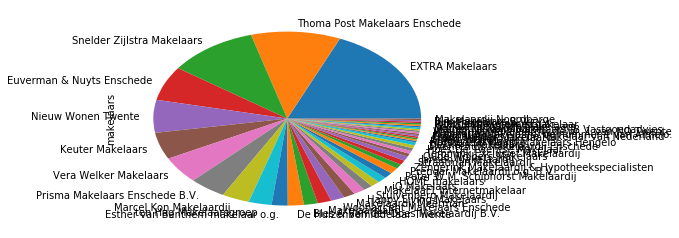

In [273]:
df['makelaars'].value_counts().plot(kind='pie')

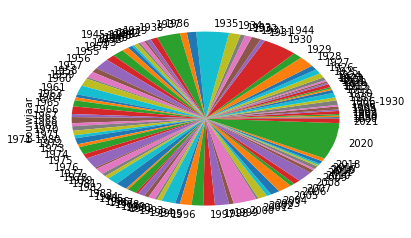

In [275]:
df['bouwjaar'].value_counts().sort_index().plot(kind='pie')

In [284]:
df[df['bouwjaar']=='2020'].sort_values(by=['woonen_m2'],ascending=False)

,link,title,city,price,bouwjaar,kamers,woonlagen,woonen_m2,perceel_m2,makelaars,makelaars_phone
178,https://www.funda.nl/koop/enschede/huis-41999170-niermansgang-5/,Niermansgang 5 7514 DM Enschede,enschede,495000,2020,3 kamers (2 slaapkamers),1 woonlaag,186,NaN,Nieuw Wonen Twente,(+31) 85 273 23 77
254,https://www.funda.nl/koop/enschede/huis-41606388-bouwnummer-bouwnr-8/,Bouwnummer (Bouwnr. 8) 7513 EV Enschede,enschede,419500,2020,6 kamers (4 slaapkamers),2 woonlagen en een zolder,162,NaN,Nieuw Wonen Twente,(+31) 85 273 23 77
116,https://www.funda.nl/koop/enschede/huis-41569443-ooster-es-bouwnr-17/,Ooster Es (Bouwnr. 17) 7514 XS Enschede,enschede,470000,2020,5 kamers (3 slaapkamers),2 woonlagen en een zolder,159,NaN,Nieuw Wonen Twente,(+31) 85 273 23 77
219,https://www.funda.nl/koop/enschede/huis-41569438-ooster-es-bouwnr-4/,Ooster Es (Bouwnr. 4) 7514 XS Enschede,enschede,410000,2020,1 kamer,1 woonlaag,158,NaN,Nieuw Wonen Twente,(+31) 85 273 23 77
10,https://www.funda.nl/koop/enschede/huis-41774606-tweede-bothofdwarsstraat-14/,Tweede Bothofdwarsstraat 14 7511 ZM Enschede,enschede,375000,2020,7 kamers (6 slaapkamers),1 badkamer en 1 apart toilet,157,NaN,Vera Welker Makelaars,(+31) 53 760 11 11
124,https://www.funda.nl/koop/enschede/huis-41891502-spinner-b2-bouwnr-1/,"Spinner, B2 (Bouwnr. 1) 7523 EX Enschede",enschede,407500,2020,5 kamers (3 slaapkamers),1 badkamer en 1 apart toilet,157,NaN,Nieuw Wonen Twente,(+31) 85 273 23 77
187,https://www.funda.nl/koop/enschede/huis-41891520-spoeler-c2-bouwnr-23/,"Spoeler, C2 (Bouwnr. 23) 7523 JP Enschede",enschede,457500,2020,5 kamers (3 slaapkamers),1 badkamer en 1 apart toilet,157,NaN,Nieuw Wonen Twente,(+31) 85 273 23 77
234,https://www.funda.nl/koop/enschede/huis-41606384-bouwnummer-bouwnr-9/,Bouwnummer (Bouwnr. 9) 7513 EV Enschede,enschede,419500,2020,4 kamers (2 slaapkamers),2 woonlagen en een zolder,156,NaN,Nieuw Wonen Twente,(+31) 85 273 23 77
229,https://www.funda.nl/koop/enschede/huis-41891538-wever-a2-bouwnr-27/,"Wever, A2 (Bouwnr. 27) 7523 JP Enschede",enschede,450000,2020,4 kamers (3 slaapkamers),1 badkamer en 1 apart toilet,154,NaN,Nieuw Wonen Twente,(+31) 85 273 23 77
211,https://www.funda.nl/koop/enschede/huis-41802502-2-moderne-herenhuizen-bouwnr-2/,2 Moderne Herenhuizen (Bouwnr. 2) 7522 CG Enschede,enschede,439500,2020,1 kamer,1 woonlaag,147,NaN,Nieuw Wonen Twente,(+31) 85 273 23 77


<h1 align='center'>=========================================================</h1> 

# PART III: enriching the data

# Bike Distance from/to SOMEWHERE

In [510]:
import googlemaps
from datetime import datetime

def gmaps_bike_distance (key, point_a, point_b):
    gmaps = googlemaps.Client(key=key)
    directions_result = gmaps.directions(point_a, point_b, mode="bicycling")
    bike_distance = directions_result[0][u'legs'][0][u'distance'][u'text'].replace(' km','')
    return float(bike_distance)

def bike_distance_from_somewhere(point_b,somewhere):
    return gmaps_bike_distance (google_key, somewhere, point_b)

## Enriching the distance from the house to SOMEWHERE

In [507]:
df['distance_ut'] = df['address'].map(lambda x: bike_distance_from_somewhere(x, somewhere))

<h1 align='center'>=========================================================</h1> 

Notes:
- karamelweg 124m2 Woonoppervlak
- hulsmaatstraat 210m2 Woonoppervlak